In [13]:
from time import time
import sys
import os
import subprocess
import platform
from urllib.request import urlretrieve
import json

sys.path.append(os.path.join(os.getcwd(), ".."))

from Extra.utils import parse_xml, translate_coco_to_images_net, clear_directory, find_xml_file, calculate_iou, get_scores

import cv2

import matplotlib.pyplot as plt
import numpy as np

In [14]:
file_path = "../../resources/yolov3.weights"

# Check if the file exists
if not os.path.exists(file_path):
    if platform.system() == "Windows":
        try:
            # Download using urllib.request for Windows
            url = "https://pjreddie.com/media/files/yolov3.weights"
            destination_path = "../../resources/yolov3.weights"
            urlretrieve(url, destination_path)
            print("File downloaded successfully.")
        except Exception as e:
            print(f"Error downloading the file: {e}")
    else:
        # For non-Windows systems, use wget
        download_command = "wget https://pjreddie.com/media/files/yolov3.weights -P ../../resources/"
        try:
            # Run the command in the terminal
            subprocess.run(download_command, shell=True, check=True)
            print("File downloaded successfully.")
        except subprocess.CalledProcessError as e:
            print(f"Error downloading the file: {e}")
else:
    print("File already exists.")

File already exists.


In [15]:
resources_directory = "../../resources/"

# Load COCO class labels
class_labels = []
with open(resources_directory + "yolo_coco.names", "rt") as f:
    class_labels = f.read().rstrip('\n').split('\n')

# Load pretrained YOLO model
net = cv2.dnn.readNet(resources_directory + "yolov3.weights", resources_directory + "yolov3.cfg")

In [16]:
inicio = time()

folder_path = "../../testImagesNet/Data/"
annotations_directory = "../../testImagesNet/Annotations/"
output_directory = "../../output/images/yolo_opencv/"
clear_directory(output_directory)

image_list = []
image_path_list = []

# List all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(('.jpg', '.png', '.jpeg', '.JPEG')):  # You can add more extensions if needed
        # Construct the full file path
        file_path = os.path.join(folder_path, filename)
        
        # Read the image and append it to the list
        img = cv2.imread(file_path)
        image_list.append(img)
        image_path_list.append(file_path)

n = 0
results = {}
for image in image_list:
    height, width = image.shape[:2]

    # Create a 4D blob from the image (resize, normalize, swap channels)
    blob = cv2.dnn.blobFromImage(image, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False)

    # Set the input to the network
    net.setInput(blob)

    # Get output layer names
    out_layer_names = net.getUnconnectedOutLayersNames()

    # Forward pass to get output
    output = net.forward(out_layer_names)

    boxes = []
    confidences = []
    class_ids = []

    for detection in output:
        for obj in detection:
            scores = obj[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(obj[0] * width)
                center_y = int(obj[1] * height)
                w = int(obj[2] * width)
                h = int(obj[3] * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply non-maximum suppression to eliminate redundant overlapping boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    colors = np.random.uniform(0, 255, size=(len(class_labels), 3))

    xml_data = parse_xml(find_xml_file(annotations_directory, image_path_list[n]))
    
    for target in xml_data:
        iou = 0

        searched_label = translate_coco_to_images_net(target["name"])

        image_iou_dict = {}
        if searched_label in results:
            image_iou_dict = results[searched_label]
        if image_path_list[n] not in image_iou_dict:
            image_iou_dict[image_path_list[n]] = []

        for i in indices:
            box = boxes[i]
            x, y, w, h = box
            label = f"{class_labels[class_ids[i]]}: {confidences[i]:.2f}"

            if (class_labels[class_ids[i]] == searched_label):
                box1 = [x, y, w+x, h+y]
                box2 = [target["xmin"], target["ymin"], target["xmax"], target["ymax"]]

                new_iou = calculate_iou(box1, box2)

                if new_iou > iou:
                    iou = new_iou

            # Draw the annotated box on the image
            color = (0, 255, 0)  # You can change the color as needed
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                

        image_iou_dict[image_path_list[n]].append(iou)
        results[searched_label] = image_iou_dict

    # Save the annotated image
    filename = os.path.join(output_directory, os.path.basename(image_path_list[n]))
    cv2.imwrite(filename, image)

    n += 1

duracion = time() - inicio

In [17]:
print(results["dog"])
print(results["train"])
print(results["apple"])

{'../../testImagesNet/Data/n02089973_1.JPEG': [0.8473717369271646], '../../testImagesNet/Data/n02089973_13.JPEG': [0.8689908256880734, 0.8114558472553699], '../../testImagesNet/Data/n02089973_2.JPEG': [0.9178747628083491], '../../testImagesNet/Data/n02089973_26.JPEG': [0.7988299206017552], '../../testImagesNet/Data/n02093859_10.JPEG': [0.9043091515577844], '../../testImagesNet/Data/n02093859_3.JPEG': [0], '../../testImagesNet/Data/n02097209_1.JPEG': [0.9460787755388612], '../../testImagesNet/Data/n02097209_12.JPEG': [0.8605300391655999, 0], '../../testImagesNet/Data/n02097209_8.JPEG': [0.7993061606222173], '../../testImagesNet/Data/n02105855_5.JPEG': [0], '../../testImagesNet/Data/n02111277_25.JPEG': [0], '../../testImagesNet/Data/n02112018_2991.JPEG': [0.8345122653884346], '../../testImagesNet/Data/n02112018_3024.JPEG': [0], '../../testImagesNet/Data/n02112018_3033.JPEG': [0.8367220313096602], '../../testImagesNet/Data/n02112018_3054.JPEG': [0.8727528297699194], '../../testImagesNet/D

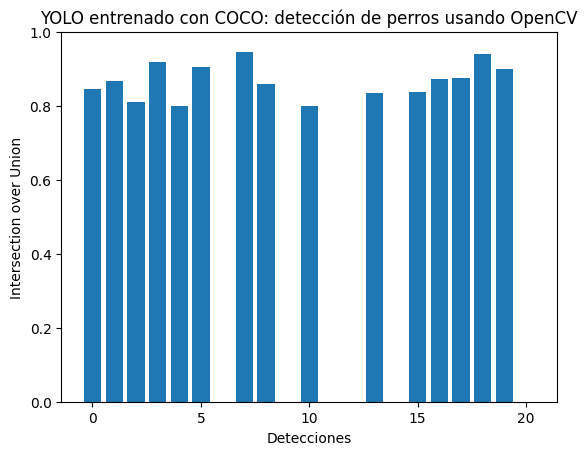

In [18]:
data = results["dog"]

merged_array = np.concatenate(list(data.values()))

# Create bar chart
plt.bar(range(len(merged_array)), merged_array)

# Set the y-axis limits to ensure the range is between 0 and 1
plt.ylim(0, 1)

# Add labels and title
plt.xlabel('Detecciones')
plt.ylabel('Intersection over Union')
plt.title('YOLO entrenado con COCO: detección de perros usando OpenCV')

# Show the plot
plt.show()

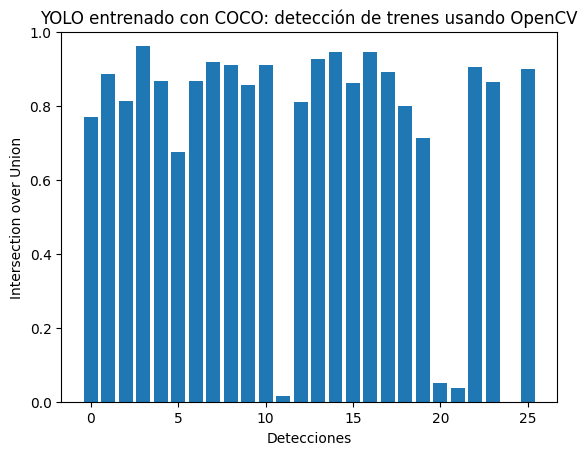

In [19]:
data = results["train"]

merged_array = np.concatenate(list(data.values()))

# Create bar chart
plt.bar(range(len(merged_array)), merged_array)

# Set the y-axis limits to ensure the range is between 0 and 1
plt.ylim(0, 1)

# Add labels and title
plt.xlabel('Detecciones')
plt.ylabel('Intersection over Union')
plt.title('YOLO entrenado con COCO: detección de trenes usando OpenCV')

# Show the plot
plt.show()

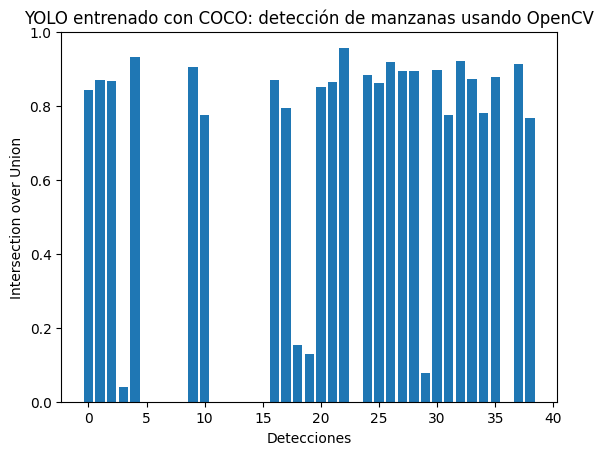

In [20]:
data = results["apple"]

merged_array = np.concatenate(list(data.values()))

# Create bar chart
plt.bar(range(len(merged_array)), merged_array)

# Set the y-axis limits to ensure the range is between 0 and 1
plt.ylim(0, 1)

# Add labels and title
plt.xlabel('Detecciones')
plt.ylabel('Intersection over Union')
plt.title('YOLO entrenado con COCO: detección de manzanas usando OpenCV')

# Show the plot
plt.show()

## Métricas de error

In [21]:
threshold = 0.5
# Specify the file path where you want to export the dictionary
score_export_folder_path = "../../output/scores/"

In [22]:
data = results["dog"]

merged_array = np.concatenate(list(data.values()))

scores = get_scores(merged_array, threshold)

print("Average IoU: " + str(scores["average_iou"]))
print("Precision: " + str(scores["precision"]))
print("Recall: " + str(scores["recall"]))
print("F1-score: " + str(scores["f1"]))
print("MSE: " + str(scores["mse"]))
print("MAE: " + str(scores["mae"]))
print("MLSE: " + str(scores["mlse"]))

scores["time"] = duracion

score_export_file_path = "yolo_dog_opencv_scores.json"
# Export the dictionary to a JSON file
with open(score_export_folder_path + score_export_file_path, 'w') as file:
    json.dump(scores, file)

Average IoU: 0.6198256429037862
Precision: 1.0
Recall: 0.7142857142857143
F1-score: 0.8333333333333333
MSE: 0.29971154789611953
MAE: 0.3801743570962138
MLSE: 0.14107525506593763


In [23]:
data = results["train"]

merged_array = np.concatenate(list(data.values()))

scores = get_scores(merged_array, threshold)

print("Average IoU: " + str(scores["average_iou"]))
print("Precision: " + str(scores["precision"]))
print("Recall: " + str(scores["recall"]))
print("F1-score: " + str(scores["f1"]))
print("MSE: " + str(scores["mse"]))
print("MAE: " + str(scores["mae"]))
print("MLSE: " + str(scores["mlse"]))

scores["time"] = duracion

score_export_file_path = "yolo_train_opencv_scores.json"
# Export the dictionary to a JSON file
with open(score_export_folder_path + score_export_file_path, 'w') as file:
    json.dump(scores, file)

Average IoU: 0.735267801275872
Precision: 0.88
Recall: 0.9565217391304348
F1-score: 0.9166666666666666
MSE: 0.16616904013107
MAE: 0.264732198724128
MLSE: 0.07432966997665194


In [24]:
data = results["apple"]

merged_array = np.concatenate(list(data.values()))

scores = get_scores(merged_array, threshold)

print("Average IoU: " + str(scores["average_iou"]))
print("Precision: " + str(scores["precision"]))
print("Recall: " + str(scores["recall"]))
print("F1-score: " + str(scores["f1"]))
print("MSE: " + str(scores["mse"]))
print("MAE: " + str(scores["mae"]))
print("MLSE: " + str(scores["mlse"]))

scores["time"] = duracion

score_export_file_path = "yolo_apple_opencv_scores.json"
# Export the dictionary to a JSON file
with open(score_export_folder_path + score_export_file_path, 'w') as file:
    json.dump(scores, file)

Average IoU: 0.5433904006260838
Precision: 0.8571428571428571
Recall: 0.6857142857142857
F1-score: 0.7619047619047619
MSE: 0.3780784486423801
MAE: 0.4566095993739164
MLSE: 0.1759607751765954
